Para resolver este ejercicio encontrarás adjunto una carpeta comprimida con una serie de tablas (lego-database.zip).

Imagina que tú eres el encargado del área de compras de LEGO y debes preparar la estrategia de compras para las campañas de este año.

Este año se tendrá especial énfasis en 3 temáticas con las siguientes expectativas de producción:
1. Star Wars: 5.000.000 unidades
2. Héroes: 5.000.000 unidades
3. Building: 5.000.000 unidades

La producción de estas nuevas unidades empieza en 1 mes y no se tienen piezas en inventario.

### Análisis de la Estructura de la Base de Datos

Según el esquema proporcionado, las tablas importantes para este análisis son:

- **`inventory_sets`**: Para obtener los inventarios relacionados con los sets.
- **`sets`**: Para identificar los sets por nombre y tema (como "Star Wars", "Héroes", "Building").
- **`themes`**: Para categorizar los temas de los sets.
- **`inventory_parts`**: Para identificar las piezas necesarias para los sets específicos.
- **`colors`**: Para obtener los colores de las piezas necesarias.
- **`parts`** y **`part_categories`**: Para obtener información adicional sobre los tipos y categorías de piezas.

<p align="center">
  <img src="./Data/downloads_schema.png" alt="LEGO Logo">
</p>

### Determinación de Cantidad y Proporciones de Colores para Producción

Para alcanzar una producción de 5,000,000 unidades para los temas "Star Wars", "Heroes" y "Building", se sigue un enfoque sistemático que involucra un análisis detallado de los datos disponibles. El proceso se desglosa de la siguiente manera:

#### Filtrado por Temática
Comenzamos con la tabla `themes` para identificar los temas de interés. Los temas permiten focalizar las áreas de producción y reducen el rango de interés a conjuntos específicos. En el caso de LEGO, los temas son cruciales para determinar qué sets se fabrican y cuál es el equipo responsable.

#### Relación con Sets
Usamos la información de `themes` para filtrar los sets asociados a cada tema. Esto se logra mediante la clave foránea `theme_id` en la tabla `sets`, que se vincula con `id` en la tabla `themes`.

#### Filtrado de Inventarios
Una vez obtenidos los sets relevantes, filtramos los inventarios asociados a esos sets utilizando la clave foránea `set_num` en la tabla `inventories`, que corresponde a `set_num` en `sets`.

#### Obtención de Piezas
Con los inventarios filtrados, conectamos con la tabla `inventory_parts` para obtener detalles sobre las piezas utilizadas en cada inventario. Esta tabla se une con `colors` a través de la clave `color_id` en `inventory_parts` y `id` en `colors`.

#### Cálculo de Proporciones de Colores
Finalmente, con la información de piezas y colores, calculamos la distribución de colores, ajustando las cantidades según la producción requerida. Esto implica calcular la proporción de cada color en base al total de piezas y escalar estas proporciones para cumplir con el objetivo de producción.

### Flujo de Trabajo Implementado

- **Ruta de Filtrado (amarillo)**: Incluye la selección de datos basados en los temas, sets, y inventarios específicos.
- **Ruta de Unión de Tablas (verde)**: Incluye la combinación de datos de diferentes tablas para obtener la distribución de colores.

Esta metodología asegura una comprensión clara de los requisitos de colores para la producción deseada, proporcionando una base sólida para planificar y ejecutar la fabricación de sets de LEGO.

In [29]:
import pandas as pd
import os
import plotly.io as pio

# Cambiar la configuración para que Plotly incruste los gráficos en el HTML
pio.renderers.default = 'notebook_connected'

extract_dir = './Data'
# Cargar los archivos CSV en DataFrames
colors_df = pd.read_csv(os.path.join(extract_dir, 'colors.csv'))
inventories_df = pd.read_csv(os.path.join(extract_dir, 'inventories.csv'))
inventory_parts_df = pd.read_csv(os.path.join(extract_dir, 'inventory_parts.csv'))
inventory_sets_df = pd.read_csv(os.path.join(extract_dir, 'inventory_sets.csv'))
part_categories_df = pd.read_csv(os.path.join(extract_dir, 'part_categories.csv'))
parts_df = pd.read_csv(os.path.join(extract_dir, 'parts.csv'))
sets_df = pd.read_csv(os.path.join(extract_dir, 'sets.csv'))
themes_df = pd.read_csv(os.path.join(extract_dir, 'themes.csv'))

# Agregar el nombre del tema a los sets uniendo con themes
sets_with_themes_df = sets_df.merge(themes_df, left_on='theme_id', right_on='id', suffixes=('_set', '_theme'))
sets_with_themes_df.rename(columns={'name_theme': 'theme_name'}, inplace=True)

# Filtrar sets para las temáticas seleccionadas
selected_themes = ["Star Wars", "Heroes", "Building"]
sets_in_selected_themes_df = sets_with_themes_df[sets_with_themes_df['theme_name'].isin(selected_themes)]

# Definir la producción requerida por tema
production_requirements = {
    'Star Wars': 5000000,
    'Heroes': 5000000,
    'Building': 5000000
}

# Función para obtener la distribución de colores por tema
def calculate_color_distribution(theme_name, production_required):
    # Filtrar sets del tema específico
    theme_sets_df = sets_with_themes_df[sets_with_themes_df['theme_name'] == theme_name]
    
    # Unir sets con los inventarios y luego con las piezas para obtener las partes involucradas
    selected_inventories_df = inventories_df[inventories_df['set_num'].isin(theme_sets_df['set_num'])]
    selected_inventory_parts_df = inventory_parts_df[inventory_parts_df['inventory_id'].isin(selected_inventories_df['id'])]
    
    # Unir con la tabla de colores para obtener la distribución de colores
    color_distribution_df = selected_inventory_parts_df.merge(colors_df, left_on='color_id', right_on='id')

    # Obtenemos las partes del inventario de los sets del tema
    inventory_parts_filtered = color_distribution_df
    
    # Calcular la cantidad total de piezas en el tema
    total_pieces_theme = color_distribution_df['quantity'].sum()
    
    # Calcular las proporciones de piezas escaladas a la producción requerida
    color_distribution_df['scaled_quantity'] = (color_distribution_df['quantity'] / total_pieces_theme) * production_required
    
    # Agrupar por color para obtener el total por color
    color_proportions = color_distribution_df.groupby('name').agg({'quantity': 'sum', 'scaled_quantity': 'sum'}).reset_index()
    total_pieces_theme = color_distribution_df.groupby('part_num').agg({'quantity': 'sum', 'scaled_quantity': 'sum'}).reset_index()
    
    return color_proportions, total_pieces_theme

def get_parts_categories_count(total_pieces_theme):
    parts = parts_df[parts_df['part_num'].isin(total_pieces_theme['part_num'])]
    parts_categories = part_categories_df[part_categories_df['id'].isin(parts['part_cat_id'])].drop_duplicates()
    parts_categories.reset_index(drop=True, inplace=True)

    return parts_categories
# Obtener la distribución de colores para cada temática

star_wars_distribution,total_pieces_theme_star_wars = calculate_color_distribution('Star Wars', production_requirements['Star Wars'])
print('Distribución de colores para Star Wars')
star_wars_distribution




Distribución de colores para Star Wars


,name,quantity,scaled_quantity
0,Black,8935,1.237260e+06
1,Blue,834,1.154869e+05
2,Bright Green,9,1.246261e+03
3,Bright Light Orange,5,6.923673e+02
4,Bright Light Yellow,2,2.769469e+02
...,...,...,...
59,Unknown,1,1.384735e+02
60,Violet,35,4.846571e+03
61,White,2288,3.168273e+05
62,Yellow,338,4.680403e+04


In [43]:
parts_categories_star_wars = get_parts_categories_count(total_pieces_theme_star_wars)
print('Cantidad de categorías de piezas en Star Wars', len(parts_categories_star_wars))
parts_categories_star_wars


Cantidad de categorías de piezas en Star Wars 48


,id,name
0,2,Bricks Printed
1,3,Bricks Sloped
2,5,Bricks Special
3,6,Bricks Wedged
4,7,Containers
5,8,Technic Bricks
6,9,Plates Special
7,10,Tiles Printed
8,11,Bricks
9,12,Technic Connectors


In [36]:
heroes_distribution, total_pieces_theme_heroes = calculate_color_distribution('Heroes', production_requirements['Heroes'])
print("Distribución de colores para Héroes:")
heroes_distribution

Distribución de colores para Héroes:


,name,quantity,scaled_quantity
0,Black,627,1.290655e+06
1,Blue,211,4.343351e+05
2,Bright Green,4,8.233841e+03
3,Bright Light Orange,12,2.470152e+04
4,Dark Bluish Gray,205,4.219844e+05
5,Dark Brown,4,8.233841e+03
6,Dark Green,4,8.233841e+03
7,Dark Purple,3,6.175381e+03
8,Dark Tan,11,2.264306e+04
9,Flat Silver,185,3.808152e+05


In [42]:
parts_categories_heroes = get_parts_categories_count(total_pieces_theme_heroes)
print('Cantidad de categorías de piezas en Heroes:', len(parts_categories_heroes))
parts_categories_heroes

Cantidad de categorías de piezas en Heroes: 27


,id,name
0,9,Plates Special
1,10,Tiles Printed
2,12,Technic Connectors
3,13,Minifigs
4,15,Tiles Special
5,18,"Hinges, Arms and Turntables"
6,19,Tiles
7,20,Bricks Round and Cones
8,21,Plates Round and Dishes
9,25,"Technic Steering, Suspension and Engine"


In [40]:
building_distribution,total_pieces_theme_building = calculate_color_distribution('Building', production_requirements['Building'])
print("Distribución de colores para Building:")
building_distribution

Distribución de colores para Building:


,name,quantity,scaled_quantity
0,Black,1558,428988.380417
1,Blue,1224,337022.963820
2,Bright Green,40,11013.822347
3,Bright Light Orange,6,1652.073352
4,Brown,11,3028.801145
5,Dark Blue,132,36345.613745
6,Dark Bluish Gray,1120,308387.025717
7,Dark Brown,15,4130.183380
8,Dark Gray,10,2753.455587
9,Dark Green,12,3304.146704


In [44]:
parts_categories_building = get_parts_categories_count(total_pieces_theme_building)
print('Cantidad de categorías de piezas en Heroes:', len(parts_categories_building))
parts_categories_building


Cantidad de categorías de piezas en Heroes: 39


,id,name
0,1,Baseplates
1,2,Bricks Printed
2,3,Bricks Sloped
3,5,Bricks Special
4,6,Bricks Wedged
5,7,Containers
6,8,Technic Bricks
7,9,Plates Special
8,10,Tiles Printed
9,11,Bricks


In [46]:
import pandas as pd
import os

extract_dir = './Data'
# Cargar los archivos CSV en DataFrames
colors_df = pd.read_csv(os.path.join(extract_dir, 'colors.csv'))
inventories_df = pd.read_csv(os.path.join(extract_dir, 'inventories.csv'))
inventory_parts_df = pd.read_csv(os.path.join(extract_dir, 'inventory_parts.csv'))
inventory_sets_df = pd.read_csv(os.path.join(extract_dir, 'inventory_sets.csv'))
part_categories_df = pd.read_csv(os.path.join(extract_dir, 'part_categories.csv'))
parts_df = pd.read_csv(os.path.join(extract_dir, 'parts.csv'))
sets_df = pd.read_csv(os.path.join(extract_dir, 'sets.csv'))
themes_df = pd.read_csv(os.path.join(extract_dir, 'themes.csv'))

# Agregar el nombre del tema a los sets uniendo con themes
sets_with_themes_df = sets_df.merge(themes_df, left_on='theme_id', right_on='id', suffixes=('_set', '_theme'))
sets_with_themes_df.rename(columns={'name_theme': 'theme_name'}, inplace=True)

# Filtrar sets para las temáticas seleccionadas
selected_themes = ["Star Wars", "Heroes", "Building"]
sets_in_selected_themes_df = sets_with_themes_df[sets_with_themes_df['theme_name'].isin(selected_themes)]

# Función para obtener la cantidad de piezas por set en cada temática
def calculate_pieces_per_theme(theme_name):
    # Filtrar sets del tema específico
    theme_sets_df = sets_with_themes_df[sets_with_themes_df['theme_name'] == theme_name]
    
    # Unir sets con los inventarios y luego con las piezas para obtener las cantidades
    selected_inventories_df = inventories_df[inventories_df['set_num'].isin(theme_sets_df['set_num'])]
    selected_inventory_parts_df = inventory_parts_df[inventory_parts_df['inventory_id'].isin(selected_inventories_df['id'])]
    
    # Calcular el total de piezas por set
    pieces_per_set_df = selected_inventory_parts_df.groupby('inventory_id').agg(total_pieces=('quantity', 'sum')).reset_index()
    
    # Unir los inventarios con los sets para obtener el número de sets
    pieces_per_set_df = pieces_per_set_df.merge(selected_inventories_df[['id', 'set_num']], left_on='inventory_id', right_on='id')
    
    return pieces_per_set_df

# Obtener la cantidad de piezas por set para cada temática
star_wars_pieces = calculate_pieces_per_theme('Star Wars')
heroes_pieces = calculate_pieces_per_theme('Heroes')
building_pieces = calculate_pieces_per_theme('Building')

# Función para calcular estadísticas de las piezas por set
def analyze_pieces_distribution(pieces_df, theme_name):
    print(f"Análisis estadístico para {theme_name}:")
    print("Promedio de piezas por set:", pieces_df['total_pieces'].mean())
    print("Mediana de piezas por set:", pieces_df['total_pieces'].median())
    print("Desviación estándar:", pieces_df['total_pieces'].std())
    print("Mínimo de piezas:", pieces_df['total_pieces'].min())
    print("Máximo de piezas:", pieces_df['total_pieces'].max())
    print("\n")

# Analizar la distribución de piezas para cada temática
analyze_pieces_distribution(star_wars_pieces, 'Star Wars')
analyze_pieces_distribution(heroes_pieces, 'Heroes')
analyze_pieces_distribution(building_pieces, 'Building')


Análisis estadístico para Star Wars:
Promedio de piezas por set: 183.28934010152284
Mediana de piezas por set: 22.0
Desviación estándar: 420.55601259847134
Mínimo de piezas: 1
Máximo de piezas: 4094


Análisis estadístico para Heroes:
Promedio de piezas por set: 59.24390243902439
Mediana de piezas por set: 44.0
Desviación estándar: 53.95126527144886
Mínimo de piezas: 17
Máximo de piezas: 294


Análisis estadístico para Building:
Promedio de piezas por set: 330.1636363636364
Mediana de piezas por set: 174.0
Desviación estándar: 587.6796419956722
Mínimo de piezas: 3
Máximo de piezas: 4259




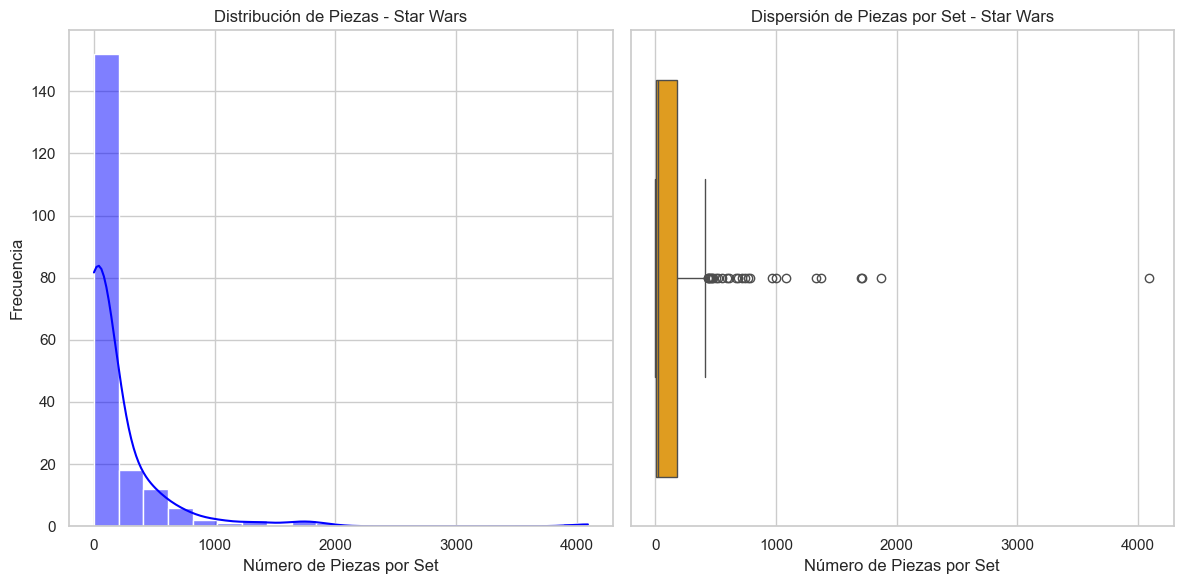

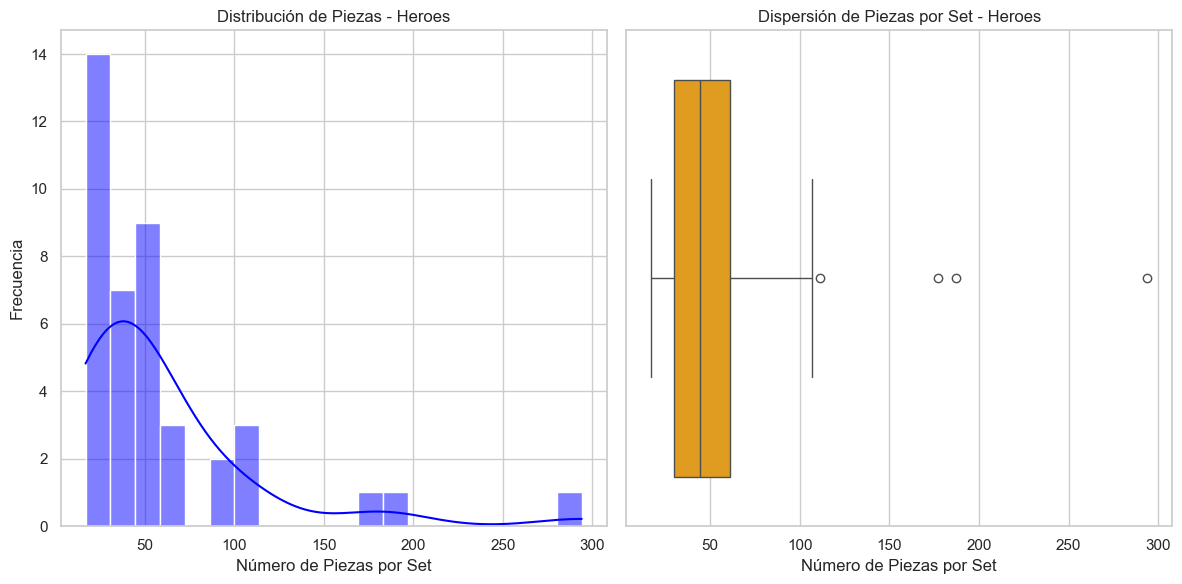

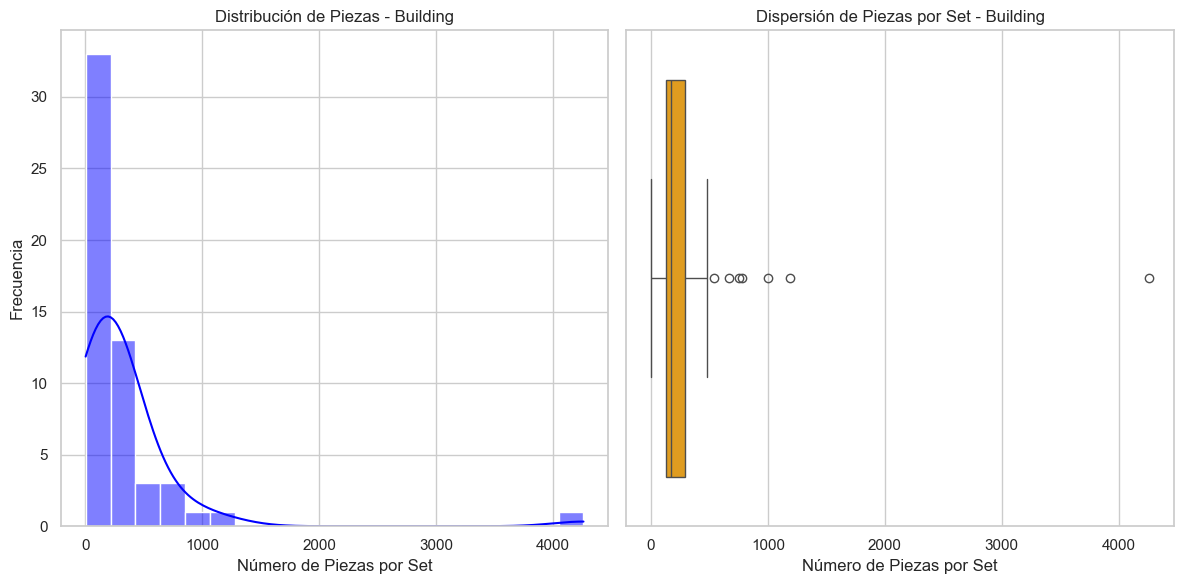

C:\Users\MSI-Sebas\AppData\Local\Temp\ipykernel_24848\64063289.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(average_pieces.keys()), y=list(average_pieces.values()), palette='viridis')


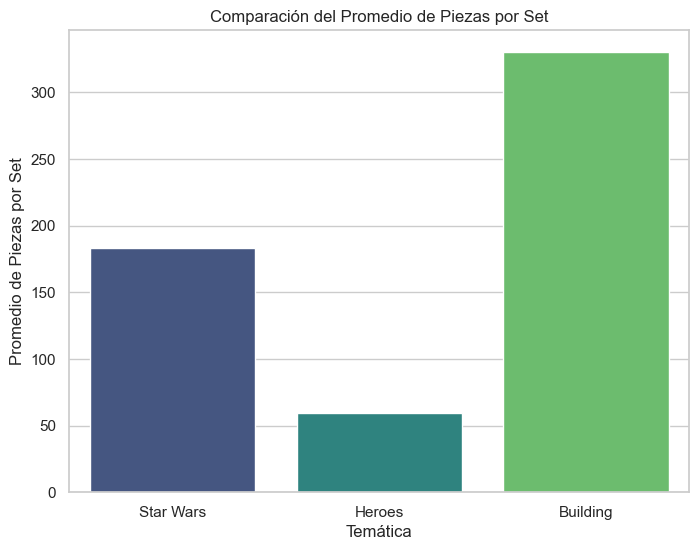

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos
sns.set(style="whitegrid")

# Función para generar gráficos de relevancia
def plot_pieces_distribution(pieces_df, theme_name):
    plt.figure(figsize=(12, 6))
    
    # Histograma de la distribución de piezas
    plt.subplot(1, 2, 1)
    sns.histplot(pieces_df['total_pieces'], bins=20, kde=True, color='blue')
    plt.title(f'Distribución de Piezas - {theme_name}')
    plt.xlabel('Número de Piezas por Set')
    plt.ylabel('Frecuencia')
    
    # Boxplot para mostrar la dispersión de piezas
    plt.subplot(1, 2, 2)
    sns.boxplot(data=pieces_df, x='total_pieces', color='orange')
    plt.title(f'Dispersión de Piezas por Set - {theme_name}')
    plt.xlabel('Número de Piezas por Set')
    
    plt.tight_layout()
    plt.show()

# Graficar la distribución para Star Wars
plot_pieces_distribution(star_wars_pieces, 'Star Wars')

# Graficar la distribución para Heroes
plot_pieces_distribution(heroes_pieces, 'Heroes')

# Graficar la distribución para Building
plot_pieces_distribution(building_pieces, 'Building')

# Comparar el promedio de piezas por set entre temáticas
def plot_average_pieces_comparison(star_wars_pieces, heroes_pieces, building_pieces):
    # Calcular el promedio de piezas para cada temática
    average_pieces = {
        'Star Wars': star_wars_pieces['total_pieces'].mean(),
        'Heroes': heroes_pieces['total_pieces'].mean(),
        'Building': building_pieces['total_pieces'].mean()
    }

    # Crear gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(average_pieces.keys()), y=list(average_pieces.values()), palette='viridis')
    plt.title('Comparación del Promedio de Piezas por Set')
    plt.ylabel('Promedio de Piezas por Set')
    plt.xlabel('Temática')
    plt.show()

# Comparar el promedio de piezas entre temáticas
plot_average_pieces_comparison(star_wars_pieces, heroes_pieces, building_pieces)


### Conclusiones a partir de las Gráficas y el Análisis Estadístico

#### 1. Star Wars
- **Promedio y Mediana**: El promedio de piezas por set es de 183.29, pero la mediana es mucho menor, con solo 22 piezas. Esta diferencia notable entre la media y la mediana indica una distribución asimétrica, sesgada hacia la derecha, lo que significa que hay algunos sets con muchas más piezas que la mayoría, elevando la media.
- **Desviación Estándar**: La desviación estándar de 420.56 indica una gran dispersión en el número de piezas entre los sets. Los gráficos de dispersión también lo corroboran, mostrando que algunos sets son outliers con un número de piezas extremadamente alto.
- **Distribución**: La mayoría de los sets tienen muy pocas piezas, pero hay algunos sets con hasta 4094 piezas, lo que provoca la larga cola en la distribución. Esto es típico en temáticas como Star Wars, que incluye sets desde los más pequeños hasta los más grandes y complejos.
- **Conclusión**: En Star Wars, la mayoría de los sets son pequeños, pero hay algunos sets grandes que distorsionan la media y aumentan la dispersión. El análisis muestra una fuerte concentración de sets pequeños y pocos pero importantes outliers (sets con miles de piezas).

#### 2. Heroes
- **Promedio y Mediana**: El promedio es de 59.24 piezas, mientras que la mediana es 44 piezas. En este caso, la diferencia entre la media y la mediana es pequeña, lo que indica una distribución más simétrica en comparación con Star Wars.
- **Desviación Estándar**: La desviación estándar es mucho más baja (53.95), lo que sugiere que la variación en el número de piezas entre los sets de esta temática es relativamente pequeña.
- **Distribución**: El gráfico muestra una dispersión más estrecha, con pocos outliers, lo que respalda los datos estadísticos. El set más grande tiene 294 piezas, mucho menor que los máximos en las otras dos temáticas.
- **Conclusión**: Los sets de Heroes son más consistentes en tamaño, con una dispersión baja y una mayor concentración de sets de tamaño similar. Esto se refleja en la baja desviación estándar y la menor diferencia entre la media y la mediana.

#### 3. Building
- **Promedio y Mediana**: El promedio es de 330.16 piezas, pero la mediana es de 174. Esta diferencia notable entre la media y la mediana nuevamente sugiere una distribución sesgada hacia la derecha, con sets más grandes que elevan el promedio.
- **Desviación Estándar**: La desviación estándar es la más alta de las tres temáticas (587.68), indicando una gran variabilidad en el número de piezas por set. Esto se corrobora en los gráficos de dispersión, donde se observan muchos outliers.
- **Distribución**: Similar a Star Wars, aunque los sets medianos son más comunes que en Star Wars, también hay sets con miles de piezas, lo que genera una larga cola hacia la derecha en la distribución y múltiples outliers.
- **Conclusión**: Building también presenta una alta dispersión en el número de piezas por set. Hay sets pequeños y medianos, pero también muchos sets con miles de piezas que aumentan significativamente el promedio y la desviación estándar.